# Lesson 6: AI NPCs with Memory, Strategy, and LLM Dialogue

In this lesson, you'll learn how to combine advanced agent memory, strategic planning, and LLM-powered NPCs for a truly intelligent game world.

## 🌙 World Setting: ตำนานนครากลับฟ้า - ปัญญาเหนือกาลเวลา

**"ความทรงจำ...กลยุทธ์...และบทสนทนา คือกุญแจสู่การปลดปล่อยนครา"**

### What you'll learn:
- Integrate LLMs into a complex game state with agent memory and planning
- Enable NPCs to remember, reason, and adapt their dialogue and actions
- Use multi-turn, context-aware conversations to influence game outcomes
- Combine player and NPC strategies for emergent narrative

## 🧠 Enhanced Game State with NPCs and Memory

In [1]:
from typing import TypedDict, List, Dict, Optional, Literal, Any
from dataclasses import dataclass, field
import random
import json
from datetime import datetime

# LLM integration imports
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
# --- MCP/DeepWiki integration ---
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
openai_client = OpenAI()

In [2]:
# --- Data Structures: Player, NPC, and Game State ---
@dataclass
class Item:
    name: str
    type: str
    value: int
    properties: Dict = field(default_factory=dict)

@dataclass
class NPCPersonality:
    name: str
    type: Literal["spirit", "merchant", "monk", "guardian", "sage", "librarian"]
    personality_traits: List[str]
    knowledge_domains: List[str]
    relationship_status: float
    dialogue_style: str
    memory_of_player: List[str] = field(default_factory=list)
    conversation_history: List[Dict] = field(default_factory=list)

class GameStateWithMemoryAndNPCs(TypedDict):
    player_position: Dict[str, int]
    พลังชีวิต: int
    พลังชีวิตสูงสุด: int
    มานตรา: int
    inventory: List[Dict]
    equipped_items: Dict[str, Optional[Dict]]
    current_area: str
    discovered_areas: List[str]
    enemies_nearby: List[Dict]
    short_term_memory: List[str]
    long_term_goals: List[str]
    completed_objectives: List[str]
    current_cycle: int
    cycle_memory: List[Dict]
    curse_progress: float
    current_strategy: str
    risk_tolerance: float
    decision_history: List[Dict]
    game_phase: Literal["exploration", "combat", "dialogue", "ritual", "trading"]
    turn_count: int
    messages: List[str]
    # NPCs
    active_npcs: Dict[str, Dict]
    npc_relationships: Dict[str, float]
    current_conversation: Optional[Dict]
    conversation_history: Dict[str, List[Dict]]
    player_reputation: Dict[str, int]
    knowledge_gained: List[str]
    llm_context: Dict[str, Any]
    external_knowledge: Dict[str, Any]
    dialogue_options: List[str]

## 🤖 LLM-Powered NPCs with Memory

In [3]:
class IntelligentNPC:
    def __init__(self, personality: NPCPersonality, llm_model: str = "gpt-4o-mini"):
        self.personality = personality
        self.llm = ChatOpenAI(model=llm_model, temperature=0.7)
        self.openai_client = openai_client

    def create_system_prompt(self, game_context: Dict) -> str:
        base_prompt = f"""คุณคือ {self.personality.name} ({self.personality.type}) ในเกม ตำนานนครากลับฟ้า
บุคลิกภาพ: {', '.join(self.personality.personality_traits)}
ความรู้เฉพาะด้าน: {', '.join(self.personality.knowledge_domains)}
ความสัมพันธ์กับผู้เล่น: {self.personality.relationship_status:.1f}
สไตล์การพูด: {self.personality.dialogue_style}
สถานที่: {game_context.get('current_area', 'ไม่ทราบ')}
วัฏจักรกาล: {game_context.get('current_cycle', 1)}
ระดับคำสาป: {game_context.get('curse_progress', 0):.1%}
จำไว้: พูดแบบไทยโบราณผสมสมัยใหม่, แสดงบุคลิก, ใช้ความรู้, จำประวัติสนทนา, ตอบสนองตามความสัมพันธ์
ตอบกลับในรูปแบบ JSON:
{{
  "text": "...ข้อความสนทนา...",
  "emotion": "...อารมณ์...",
  "relationship_change": ...
}}"""
        return base_prompt

    async def mcp_deepwiki_answer(self, question: str) -> str:
        """Ask DeepWiki via MCP for external knowledge."""
        resp = self.openai_client.responses.create(
            model="gpt-4o-mini",
            tools=[
                {
                    "type": "mcp",
                    "server_label": "deepwiki",
                    "server_url": "https://mcp.deepwiki.com/mcp",
                    "require_approval": {
                        "never": {
                            "tool_names": ["ask_question", "read_wiki_structure"]
                        }
                    }
                },
            ],
            input=question,
        )
        return resp.output_text

    async def generate_response(self, player_message: str, game_context: Dict) -> Dict[str, Any]:
        # If the player message is a question, try to use MCP/DeepWiki for an answer
        use_mcp = "?" in player_message or "wiki" in player_message.lower() or "deepwiki" in player_message.lower()
        mcp_answer = None
        if use_mcp:
            try:
                mcp_answer = await asyncio.to_thread(self.mcp_deepwiki_answer, player_message)
            except Exception as e:
                mcp_answer = None
        prompt = self.create_system_prompt(game_context)
        messages = [SystemMessage(content=prompt), HumanMessage(content=player_message)]
        ai_response = await self.llm.ainvoke(messages)
        try:
            response_data = json.loads(ai_response.content)
        except Exception:
            response_data = {
                "text": ai_response.content,
                "emotion": "neutral",
                "relationship_change": 0.0
            }
        # If MCP/DeepWiki provided an answer, append it to the NPC's response
        if mcp_answer:
            response_data["text"] += f"\n\n[DeepWiki ตอบเพิ่มเติม]: {mcp_answer}"
        self.personality.relationship_status += response_data.get("relationship_change", 0.0)
        self.personality.relationship_status = max(-1.0, min(1.0, self.personality.relationship_status))
        self.personality.conversation_history.append({
            "player_message": player_message,
            "npc_response": response_data["text"],
            "timestamp": datetime.now().isoformat(),
            "context": game_context.copy()
        })
        return response_data

## 🗺️ Game State Management with Memory and NPCs

In [4]:
def update_memory(state: GameStateWithMemoryAndNPCs) -> GameStateWithMemoryAndNPCs:
    current_situation = f"วัฏจักร {state['current_cycle']} เทิร์น {state['turn_count']}: {state['game_phase']} ที่ {state['current_area']}"
    state['short_term_memory'].append(current_situation)
    if len(state['short_term_memory']) > 10:
        state['short_term_memory'] = state['short_term_memory'][-10:]
    if state['พลังชีวิต'] < state['พลังชีวิตสูงสุด'] * 0.3:
        if "หายาฟื้นฟูพลังชีวิต" not in state['long_term_goals']:
            state['long_term_goals'].append("หายาฟื้นฟูพลังชีวิต")
    if state['curse_progress'] > 0.8:
        if "ทำลายคำสาป" not in state['long_term_goals']:
            state['long_term_goals'].append("ทำลายคำสาป")
    return state

In [5]:
def strategic_planning(state: GameStateWithMemoryAndNPCs) -> GameStateWithMemoryAndNPCs:
    enemy_threat = len(state['enemies_nearby'])
    health_percentage = state['พลังชีวิต'] / state['พลังชีวิตสูงสุด']
    curse_level = state['curse_progress']
    if curse_level > 0.9:
        state['current_strategy'] = "ทำพิธีกรรมด่วน"
        state['risk_tolerance'] = 0.9
    elif health_percentage < 0.3:
        state['current_strategy'] = "หลบหลีกอันตราย"
        state['risk_tolerance'] = 0.1
    elif enemy_threat > 2:
        state['current_strategy'] = "ใช้เวทมนตร์"
        state['risk_tolerance'] = 0.3
    elif len(state['inventory']) > 15:
        state['current_strategy'] = "หาพ่อค้า"
        state['risk_tolerance'] = 0.5
    else:
        state['current_strategy'] = "สำรวจวัด"
        state['risk_tolerance'] = 0.7
    decision = {
        "cycle": state['current_cycle'],
        "turn": state['turn_count'],
        "strategy": state['current_strategy'],
        "reasoning": f"พลังชีวิต: {health_percentage:.1%}, ศัตรู: {enemy_threat}, คำสาป: {curse_level:.1%}"
    }
    state['decision_history'].append(decision)
    state['messages'].append(f"กลยุทธ์: {state['current_strategy']} (ความเสี่ยง: {state['risk_tolerance']})")
    return state

## 🤝 NPC Initialization and Dialogue

In [6]:
def initialize_npcs(state: GameStateWithMemoryAndNPCs) -> GameStateWithMemoryAndNPCs:
    area = state['current_area']
    state['active_npcs'] = {}
    npc_definitions = {
        "วัดพระแก้วใต้ดิน": [
            NPCPersonality(
                name="พระราชาผีเก่า",
                type="spirit",
                personality_traits=["ปริศนา", "รอบรู้", "เฝ้าระวัง"],
                knowledge_domains=["คำสาป", "ประวัติศาสตร์", "วัฏจักรกาล"],
                relationship_status=0.0,
                dialogue_style="พูดแบบโบราณ ลึกลับ"
            )
        ],
        "ตลาดลอยฟ้า": [
            NPCPersonality(
                name="นายอุดมสมปรารถนา",
                type="merchant",
                personality_traits=["โลภ", "ฉลาด", "ไว้ใจไม่ได้"],
                knowledge_domains=["พระเครื่อง", "ราคาของ", "เส้นทางการค้า"],
                relationship_status=-0.2,
                dialogue_style="พูดแบบพ่อค้า เห็นแก่กำไร"
            )
        ],
        "ถ้ำวิปัสสนา": [
            NPCPersonality(
                name="หลวงปู่จันทร์",
                type="monk",
                personality_traits=["สงบ", "เมตตา", "รอบคอบ"],
                knowledge_domains=["ธรรมะ", "สมาธิ", "การปลดปล่อย"],
                relationship_status=0.3,
                dialogue_style="พูดนุ่มนวล สอนใจ"
            )
        ],
        "สวนภูตผี": [
            NPCPersonality(
                name="แม่หญิงภูต",
                type="spirit",
                personality_traits=["ขี้เล่น", "ลึกลับ", "ใจดี"],
                knowledge_domains=["พืชวิเศษ", "ภูตผี", "เวทมนตร์"],
                relationship_status=0.1,
                dialogue_style="พูดสนุกสนาน มีอารมณ์ขัน"
            )
        ],
        "วิหารโบราณ": [
            NPCPersonality(
                name="อาจารย์โบราณ",
                type="sage",
                personality_traits=["ฉลาด", "เคร่งขรึม", "เจ้าระเบียบ"],
                knowledge_domains=["ประวัติศาสตร์", "เวทโบราณ", "สัญลักษณ์ลับ"],
                relationship_status=0.0,
                dialogue_style="พูดจริงจัง ใช้ศัพท์โบราณ"
            )
        ],
        "ห้องสมุดแห่งกาล": [
            NPCPersonality(
                name="บรรณารักษ์เงา",
                type="librarian",
                personality_traits=["เงียบขรึม", "ช่างสังเกต", "รักความรู้"],
                knowledge_domains=["หนังสือหายาก", "ประวัติศาสตร์", "ความลับของกาลเวลา"],
                relationship_status=0.2,
                dialogue_style="พูดเบาๆ สุภาพ"
            )
        ]
    }
    base_area = area.split('_')[0]
    if base_area in npc_definitions:
        for npc_personality in npc_definitions[base_area]:
            npc_id = f"{area}_{npc_personality.name}"
            state['active_npcs'][npc_id] = {
                "personality": npc_personality,
                "npc_instance": IntelligentNPC(npc_personality),
                "is_talking": False
            }
            if npc_id not in state['npc_relationships']:
                state['npc_relationships'][npc_id] = npc_personality.relationship_status
    state['messages'].append(f"พบ NPCs ในพื้นที่ {base_area}: {len(state['active_npcs'])} คน")
    return state

In [7]:
async def start_conversation(state: GameStateWithMemoryAndNPCs) -> GameStateWithMemoryAndNPCs:
    if not state['active_npcs']:
        state['messages'].append("ไม่มี NPC ในพื้นที่นี้")
        return state
    npc_id = list(state['active_npcs'].keys())[0]
    npc_data = state['active_npcs'][npc_id]
    npc_instance = npc_data['npc_instance']
    game_context = {
        "current_area": state['current_area'],
        "current_cycle": state['current_cycle'],
        "curse_progress": state['curse_progress'],
        "player_health": state['พลังชีวิต'],
        "player_mana": state['มานตรา'],
        "completed_objectives": state['completed_objectives']
    }
    greeting_response = await npc_instance.generate_response("สวัสดี", game_context)
    state['current_conversation'] = {
        "npc_id": npc_id,
        "npc_name": npc_instance.personality.name,
        "turns": 0,
        "context": game_context,
        "last_response": greeting_response
    }
    npc_data['is_talking'] = True
    state['messages'].append(f"เริ่มสนทนากับ {npc_instance.personality.name}")
    state['messages'].append(f"{npc_instance.personality.name}: {greeting_response['text']}")
    return state

In [8]:
async def continue_dialogue(state: GameStateWithMemoryAndNPCs) -> GameStateWithMemoryAndNPCs:
    if not state['current_conversation']:
        return await start_conversation(state)
    conv = state['current_conversation']
    npc_id = conv['npc_id']
    if npc_id not in state['active_npcs']:
        state['messages'].append("NPC เดิมไม่อยู่ในพื้นที่นี้แล้ว เริ่มสนทนาใหม่กับ NPC ในพื้นที่นี้")
        state['current_conversation'] = None
        return await start_conversation(state)
    npc_instance = state['active_npcs'][npc_id]['npc_instance']
    player_msg = "คำสาปนี้เกิดจากอะไร?" if state['curse_progress'] > 0.7 else "ข้าต้องการความช่วยเหลือ"
    response = await npc_instance.generate_response(player_msg, conv['context'])
    conv['turns'] += 1
    conv['last_response'] = response
    if 'relationship_change' in response:
        old_rel = state['npc_relationships'][npc_id]
        new_rel = max(-1.0, min(1.0, old_rel + response['relationship_change']))
        state['npc_relationships'][npc_id] = new_rel
        npc_instance.personality.relationship_status = new_rel
    if npc_id not in state['conversation_history']:
        state['conversation_history'][npc_id] = []
    state['conversation_history'][npc_id].append({
        "turn": conv['turns'],
        "player": player_msg,
        "npc": response['text'],
        "timestamp": datetime.now().isoformat()
    })
    state['messages'].append(f"ผู้เล่น: {player_msg}")
    state['messages'].append(f"{npc_instance.personality.name}: {response['text']}")
    if conv['turns'] >= 2:
        state['messages'].append(f"จบการสนทนากับ {npc_instance.personality.name}")
        state['current_conversation'] = None
        state['active_npcs'][npc_id]['is_talking'] = False
    return state

## 🌀 Exploration and Game Loop

In [9]:
def enhanced_exploration(state: GameStateWithMemoryAndNPCs) -> GameStateWithMemoryAndNPCs:
    directions = ['ทิศเหนือ', 'ทิศใต้', 'ทิศตะวันออก', 'ทิศตะวันตก']
    direction = random.choice(directions)
    if direction == 'ทิศเหนือ':
        state['player_position']['y'] += 1
    elif direction == 'ทิศใต้':
        state['player_position']['y'] -= 1
    elif direction == 'ทิศตะวันออก':
        state['player_position']['x'] += 1
    else:
        state['player_position']['x'] -= 1
    areas_with_npcs = [
        "วัดพระแก้วใต้ดิน", "ตลาดลอยฟ้า", "ถ้ำวิปัสสนา",
        "สวนภูตผี", "วิหารโบราณ", "ห้องสมุดแห่งกาล"
    ]
    new_area = f"{random.choice(areas_with_npcs)}_{state['player_position']['x']}_{state['player_position']['y']}"
    if new_area not in state['discovered_areas']:
        state['discovered_areas'].append(new_area)
        state['messages'].append(f"ค้นพบพื้นที่ใหม่: {new_area}")
        state['completed_objectives'].append(f"สำรวจ {new_area}")
        state['curse_progress'] = max(0, state['curse_progress'] - 0.03)
    state['current_area'] = new_area
    state['turn_count'] += 1
    return state

In [10]:
def should_continue_enhanced(state: GameStateWithMemoryAndNPCs) -> str:
    if state['พลังชีวิต'] <= 0:
        return "end"
    if state['curse_progress'] >= 1.0:
        return "end"
    if state['current_cycle'] >= 5:
        return "end"
    if len(state['knowledge_gained']) >= 3 and state['curse_progress'] <= 0.2:
        return "end"
    if state['turn_count'] >= 10:
        return "end"
    return "continue"

## 🕸️ Building the Game Graph

In [11]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
workflow = StateGraph(GameStateWithMemoryAndNPCs)
workflow.add_node("update_memory", update_memory)
workflow.add_node("plan_strategy", strategic_planning)
workflow.add_node("initialize_npcs", initialize_npcs)
workflow.add_node("explore", enhanced_exploration)
workflow.add_node("dialogue", continue_dialogue)
workflow.set_entry_point("update_memory")
workflow.add_edge("update_memory", "plan_strategy")
workflow.add_edge("plan_strategy", "initialize_npcs")
workflow.add_edge("initialize_npcs", "explore")
workflow.add_edge("explore", "dialogue")
workflow.add_conditional_edges(
    "dialogue",
    should_continue_enhanced,
    {
        "continue": "update_memory",
        "end": END
    }
)
app_with_npc_memory = workflow.compile(checkpointer=memory)

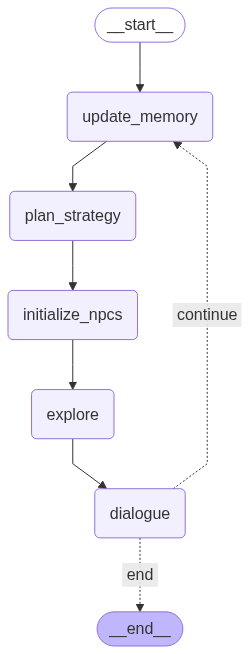

In [12]:
# --- Visualization of the Game Graph ---
# This cell generates and saves a visualization of the game workflow graph.

import os
from datetime import datetime
from IPython.display import Image

Image(app_with_npc_memory.get_graph().draw_mermaid_png())

## 🎮 Interactive Simulation: Memory, Strategy, and LLM NPCs

In [13]:
import asyncio

async def run_npc_memory_strategy_simulation():
    initial_state = {
        "player_position": {"x": 0, "y": 0},
        "พลังชีวิต": 80,
        "พลังชีวิตสูงสุด": 100,
        "มานตรา": 50,
        "inventory": [
            {"name": "พระเครื่องโบราณ", "type": "สมบัติ", "value": 100},
            {"name": "ยาสมุนไพร", "type": "ยาสมุนไพร", "value": 25}
        ],
        "equipped_items": {"weapon": None, "armor": None},
        "current_area": "วัดพระแก้วใต้ดิน",
        "discovered_areas": ["วัดพระแก้วใต้ดิน"],
        "enemies_nearby": [],
        "short_term_memory": [],
        "long_term_goals": ["ทำลายคำสาปนครากลับฟ้า"],
        "completed_objectives": [],
        "current_cycle": 1,
        "cycle_memory": [],
        "curse_progress": 0.4,
        "current_strategy": "",
        "risk_tolerance": 0.5,
        "decision_history": [],
        "game_phase": "exploration",
        "turn_count": 0,
        "messages": [],
        "active_npcs": {},
        "npc_relationships": {},
        "current_conversation": None,
        "conversation_history": {},
        "player_reputation": {"spirits": 0, "merchants": -10, "monks": 20},
        "knowledge_gained": [],
        "llm_context": {},
        "external_knowledge": {},
        "dialogue_options": []
    }
    print("🌙 === ตำนานนครากลับฟ้า: AI NPCs with Memory & Strategy ===\n")
    print('"ความทรงจำ...กลยุทธ์...และบทสนทนา คือกุญแจสู่การปลดปล่อยนครา"\n')
    try:
        turn = 0
        current_state = initial_state.copy()
        while turn < 10:
            turn += 1
            print(f"🔄 เทิร์น {turn} - วัฏจักรที่ {current_state['current_cycle']}")
            print(f"📍 สถานที่: {current_state['current_area']}")
            print(f"❤️  พลังชีวิต: {current_state['พลังชีวิต']}/{current_state['พลังชีวิตสูงสุด']} | 🔮 มานตรา: {current_state['มานตรา']}")
            print(f"🌀 คำสาป: {current_state['curse_progress']:.1%} | 🧠 ความรู้: {len(current_state['knowledge_gained'])}")
            current_state = update_memory(current_state)
            current_state = strategic_planning(current_state)
            current_state = initialize_npcs(current_state)
            current_state = enhanced_exploration(current_state)
            current_state = await continue_dialogue(current_state)
            if current_state['messages']:
                for msg in current_state['messages'][-3:]:
                    print(f"💬 {msg}")
            if current_state['npc_relationships']:
                print("🤝 ความสัมพันธ์กับ NPCs:")
                for npc_id, relationship in current_state['npc_relationships'].items():
                    npc_name = npc_id.split('_')[-1]
                    status = "💚 พันธมิตร" if relationship > 0.3 else "💛 เป็นกลาง" if relationship > -0.3 else "💔 ศัตรู"
                    print(f"   {npc_name}: {relationship:.2f} {status}")
            should_end = should_continue_enhanced(current_state)
            if should_end == "end":
                print("\n🎊 การผจญภัยสิ้นสุด!")
                break
            print("-" * 50)
            await asyncio.sleep(0.1)
        print("\n🏁 === สรุปการผจญภัยกับ NPCs และ Memory ===")
        print(f"🗺️  พื้นที่ที่ค้นพบ: {len(current_state['discovered_areas'])}")
        print(f"👥 NPCs ที่พบ: {len(current_state['npc_relationships'])}")
        print(f"💬 การสนทนาทั้งหมด: {sum(len(history) for history in current_state['conversation_history'].values())}")
        print(f"🧠 ความรู้ที่ได้รับ: {len(current_state['knowledge_gained'])}")
        return current_state
    except Exception as e:
        print(f"💥 เกิดข้อผิดพลาด: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the simulation
final_npc_memory_state = await run_npc_memory_strategy_simulation()

🌙 === ตำนานนครากลับฟ้า: AI NPCs with Memory & Strategy ===

"ความทรงจำ...กลยุทธ์...และบทสนทนา คือกุญแจสู่การปลดปล่อยนครา"

🔄 เทิร์น 1 - วัฏจักรที่ 1
📍 สถานที่: วัดพระแก้วใต้ดิน
❤️  พลังชีวิต: 80/100 | 🔮 มานตรา: 50
🌀 คำสาป: 40.0% | 🧠 ความรู้: 0
💬 ค้นพบพื้นที่ใหม่: วัดพระแก้วใต้ดิน_0_1
💬 เริ่มสนทนากับ พระราชาผีเก่า
💬 พระราชาผีเก่า: สวัสดีเจ้า ผู้มาเยือนแห่งนคราอันลึกลับ. ข้าพระราชาผีเก่าผู้เฝ้าระวังแห่งวัดพระแก้วใต้ดินนี้. มีสิ่งใดที่เจ้าต้องการสอบถามหรือไม่?
🤝 ความสัมพันธ์กับ NPCs:
   พระราชาผีเก่า: 0.00 💛 เป็นกลาง
--------------------------------------------------
🔄 เทิร์น 2 - วัฏจักรที่ 1
📍 สถานที่: วัดพระแก้วใต้ดิน_0_1
❤️  พลังชีวิต: 80/100 | 🔮 มานตรา: 50
🌀 คำสาป: 37.0% | 🧠 ความรู้: 0
💬 NPC เดิมไม่อยู่ในพื้นที่นี้แล้ว เริ่มสนทนาใหม่กับ NPC ในพื้นที่นี้
💬 เริ่มสนทนากับ พระราชาผีเก่า
💬 พระราชาผีเก่า: สวัสดีผู้อุปถัมภ์ ผู้มีจิตใจที่มีปัญญา มาเยือนถ้ำวิปัสสนานี้เพื่อค้นหาความรู้หรือไม่?
🤝 ความสัมพันธ์กับ NPCs:
   พระราชาผีเก่า: 0.00 💛 เป็นกลาง
   พระราชาผีเก่า: 0.00 💛 เป็นกลาง
----------

## 🏆 Exercises

1. **Multi-NPC Memory**: Let NPCs share memories or gossip about the player.
2. **Strategic NPCs**: Make NPCs plan their own strategies using LLMs.
3. **Dynamic World Events**: Trigger world changes based on collective NPC/player memory.
4. **Emotion-Driven Dialogue**: Use emotion in both player and NPC planning.
5. **Persistent Memory Across Cycles**: Let both player and NPCs remember past cycles.